### 한글 깨짐 방지를 위한 코드

In [ ]:
# !sudo apt-get install -y fonts-nanum #
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

## 함수 및 데이터 로드

In [1]:
from google.colab import files 
import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from scipy.stats import shapiro
from scipy import stats

In [2]:
uploaded = files.upload()

Saving vgames2.csv to vgames2 (2).csv


In [3]:
df = pd.read_csv(io.StringIO(uploaded['vgames2.csv'].decode('utf-8')))
df = df.iloc[:,1:]

## 데이터 전처리

### 결측치 제거

In [4]:
print(df.isna().sum())

features = [features for features in df.columns if df[features].isnull().sum()>1]
for feature in features:
    print(feature, np.round(df[feature].isnull().mean()*100, 4), ' % missing values.')

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64
Year 1.6327  % missing values.
Genre 0.3012  % missing values.
Publisher 0.3494  % missing values.


In [5]:
df = df.dropna(axis=0) # 결측치의 비율이 전체에 비해 미미한 바, 모두 제거하기로 결정

### 중복 데이터 확인

In [6]:
df[df.duplicated(['Name', 'Platform', 'Year', 'Publisher'], keep=False)]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
7346,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,2.11,0.23,0,0.22
8717,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,0,0.01,0,0


In [7]:
df = df.drop(index=[8717]).reset_index(drop=True)

### 데이터 변환

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16240 entries, 0 to 16239
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16240 non-null  object 
 1   Platform     16240 non-null  object 
 2   Year         16240 non-null  float64
 3   Genre        16240 non-null  object 
 4   Publisher    16240 non-null  object 
 5   NA_Sales     16240 non-null  object 
 6   EU_Sales     16240 non-null  object 
 7   JP_Sales     16240 non-null  object 
 8   Other_Sales  16240 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


#### 양적데이터 컬럼 문자열에서 숫자형으로 변환

##### 각 지역별 출고량 컬럼 숫자형으로 변환

In [9]:
numeric_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for i in range(len(numeric_cols)):
    df.loc[df[numeric_cols[i]].str.contains(r'M') == True, numeric_cols[i]] = df[numeric_cols[i]].str.replace('M', '')
    df.loc[df[numeric_cols[i]].str.contains(r'K') == True, numeric_cols[i]] = df[numeric_cols[i]].str.replace('K', '').astype(float)/1000
    df[numeric_cols[i]]= df[numeric_cols[i]].astype(float)

##### 연도 컬럼 문자열에서 숫자형으로 변환

In [10]:
df['Year'] = df['Year'].astype('int').astype('string')
df.loc[df['Year'].str.contains(r'^[89]{1}[0-9]{1}$'), 'Year'] = '19' + df[df['Year'].str.contains(r'^[89]{1}[0-9]{1}$')].Year

df.loc[df['Year'].str.contains(r'^1[0-9]{1}$'), 'Year'] = '20' + df[df['Year'].str.contains(r'^1[0-9]{1}$')].Year

df.loc[df['Year'].str.contains(r'^[0-9]{1}$'), 'Year'] = '200' + df[df['Year'].str.contains(r'^[0-9]{1}$')].Year

df = df.sort_values(by='Year').reset_index(drop=True)

### 피쳐 엔지니어링

#### 전체 출고량 컬럼 생성

In [11]:
df['Total_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales'] # 종합 판매량 컬럼 추가

#### Binning을 통한 연대 컬럼 생성

In [12]:
# Binning
interval = 10
bins = [str(s) for s in list(range(1979,2020,interval))]
groups = [str(s) for s in list(range(1980,2020,interval))]
df['Year_Group'] = pd.cut(df['Year'], bins, labels=groups)

#### 콘솔종류 컬럼 생성

In [13]:
home = ['2600', '3DO', 'DC', 'GC', 'GEN', 'N64', 'NES', 'NG', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'SAT', 'SCD', 'SNES', 'TG16', 'Wii', 'WiiU', 'X360', 'XB', 'XOne']
portable = ['3DS', 'DS', 'GB', 'GBA', 'GG', 'PSP', 'PSV', 'WS']
pc = ['PC']

df.loc[df['Platform'].isin(home), 'Console'] = 'home'
df.loc[df['Platform'].isin(portable), 'Console'] = 'portable'
df.loc[df['Platform'].isin(pc), 'Console'] = 'pc'

## 데이터 분석

### 지역 및 장르별 데이터 분석

#### 지역/장르별 데이터 분석 시각화 1

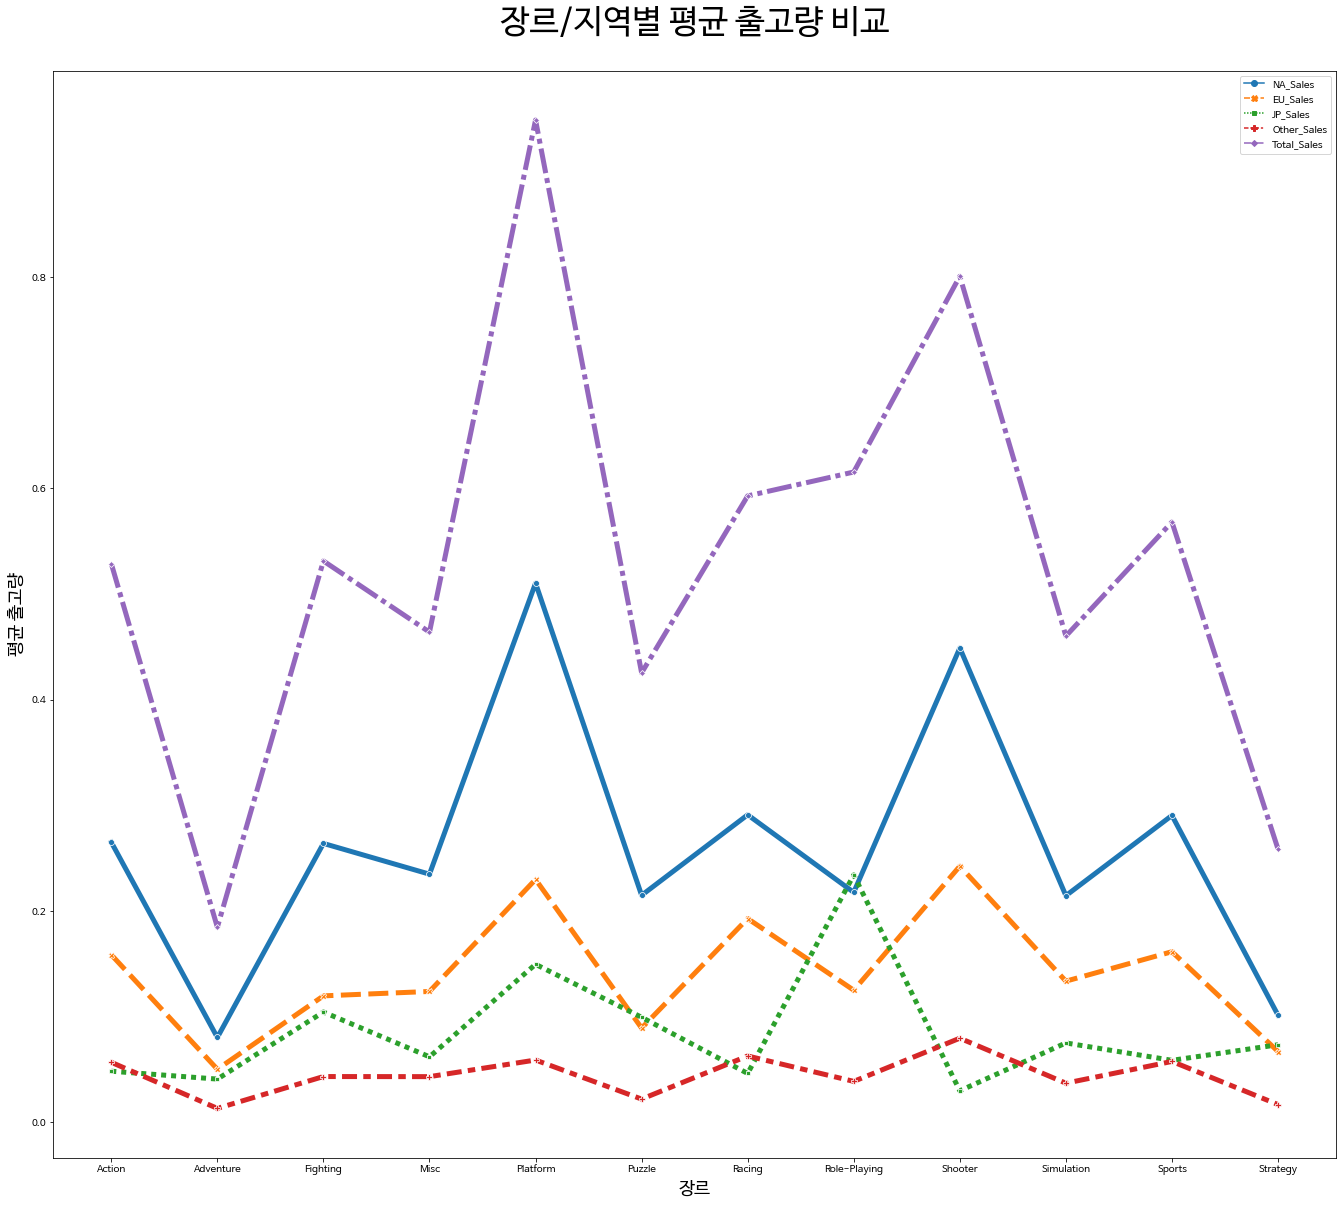

In [14]:
dfGnre =df.groupby(by=['Genre']).mean().reset_index().set_index('Genre', drop=True)
plt.figure(figsize=(23, 20))
plt.rc('font', family='NanumBarunGothic')
plt.title("장르/지역별 평균 출고량 비교", fontsize=33, loc='center', y=1.03)
plt.xlabel('장르', fontsize=18)
plt.ylabel('평균 출고량', fontsize=18)
sns.lineplot(data=dfGnre, markers=True, linewidth = 5);

#### 지역/장르별 데이터 분석 시각화 2

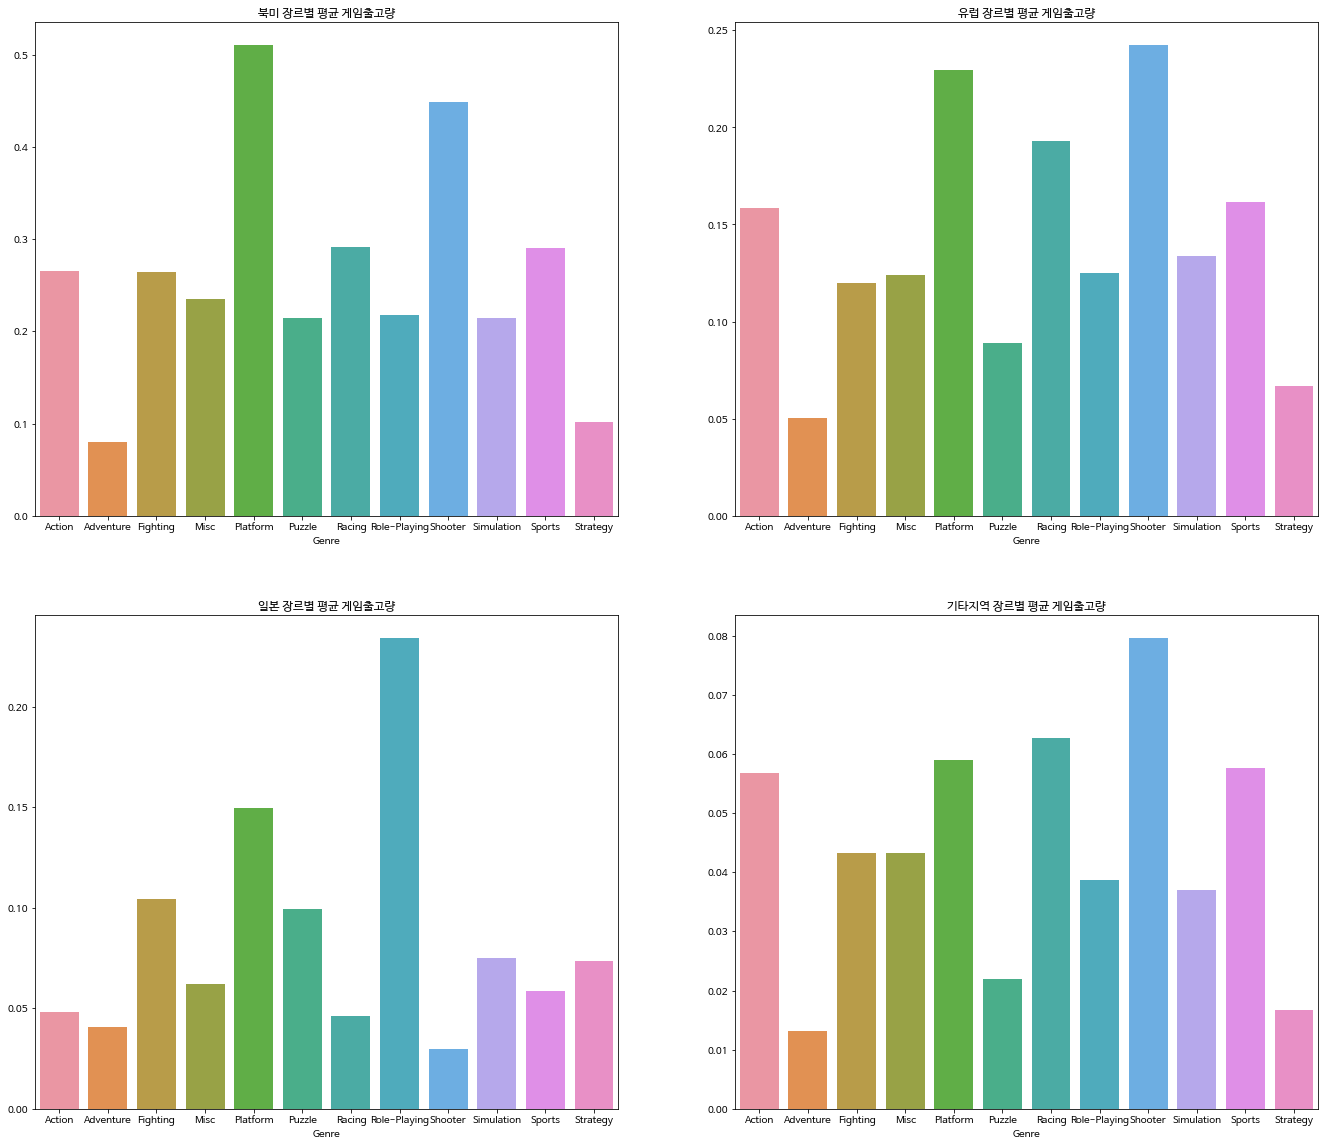

In [15]:
dataNa = dfGnre.NA_Sales
dataEu = dfGnre.EU_Sales
dataJp = dfGnre.JP_Sales
dataOther = dfGnre.Other_Sales

fig = plt.figure(figsize=(23,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.title.set_text('북미 장르별 평균 게임출고량')
ax2.title.set_text('유럽 장르별 평균 게임출고량')
ax3.title.set_text('일본 장르별 평균 게임출고량')
ax4.title.set_text('기타지역 장르별 평균 게임출고량')
sns.barplot(x=dataNa.index, y=dataNa.values, ax=ax1);
sns.barplot(x=dataEu.index, y=dataEu.values, ax=ax2);
sns.barplot(x=dataJp.index, y=dataJp.values, ax=ax3);
sns.barplot(x=dataOther.index, y=dataOther.values, ax=ax4);
plt.show()

### 연도별 트렌드 분석

#### 연도별 출시 게임 수 추이

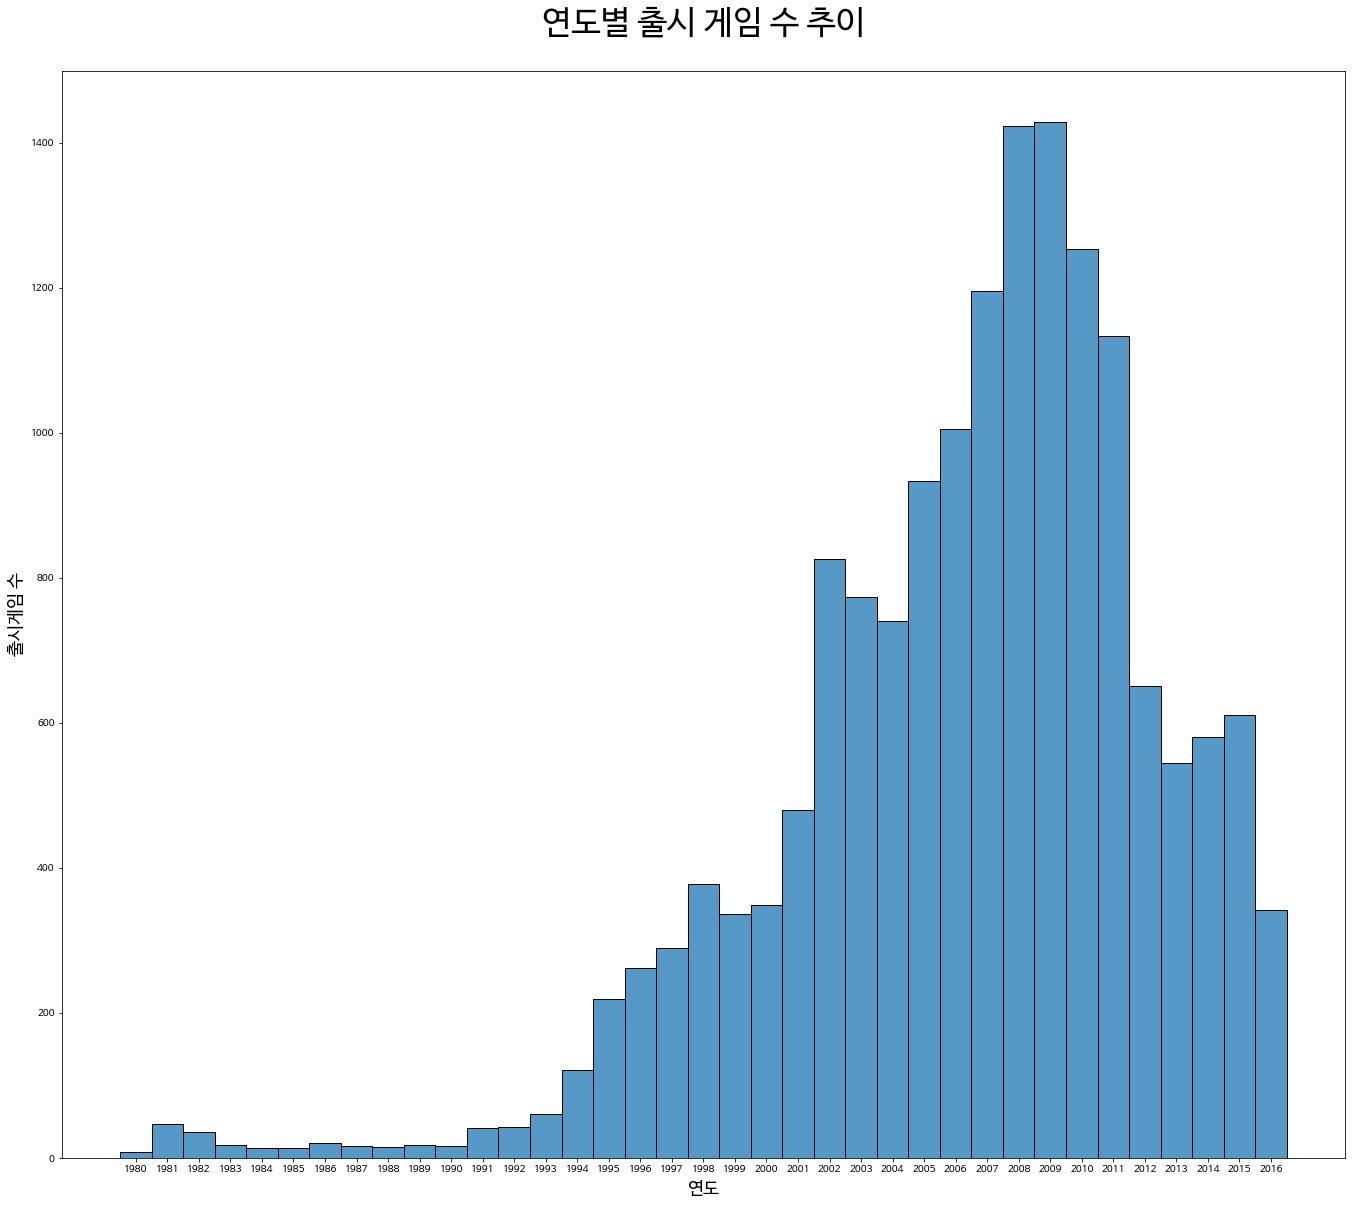

In [16]:
df = df[df['Year'] < '2017'] # 2017년과 2020년은 트렌드로 미루어 보아 데이터 불충분으로 제거 함
plt.figure(figsize=(23, 20))
plt.xlabel('연도', fontsize=18)
plt.ylabel('출시게임 수', fontsize=18)
plt.title("연도별 출시 게임 수 추이", fontsize=33, loc='center', y=1.03)
sns.histplot(df.Year);

#### 연대별 게임 출고량 추이

,Year_Group,Total_Sales,changeRatio
0,1980,375.98,NaN
1,1990,1275.19,2.391643
2,2000,4612.42,2.617045
3,2010,2491.43,-0.459843


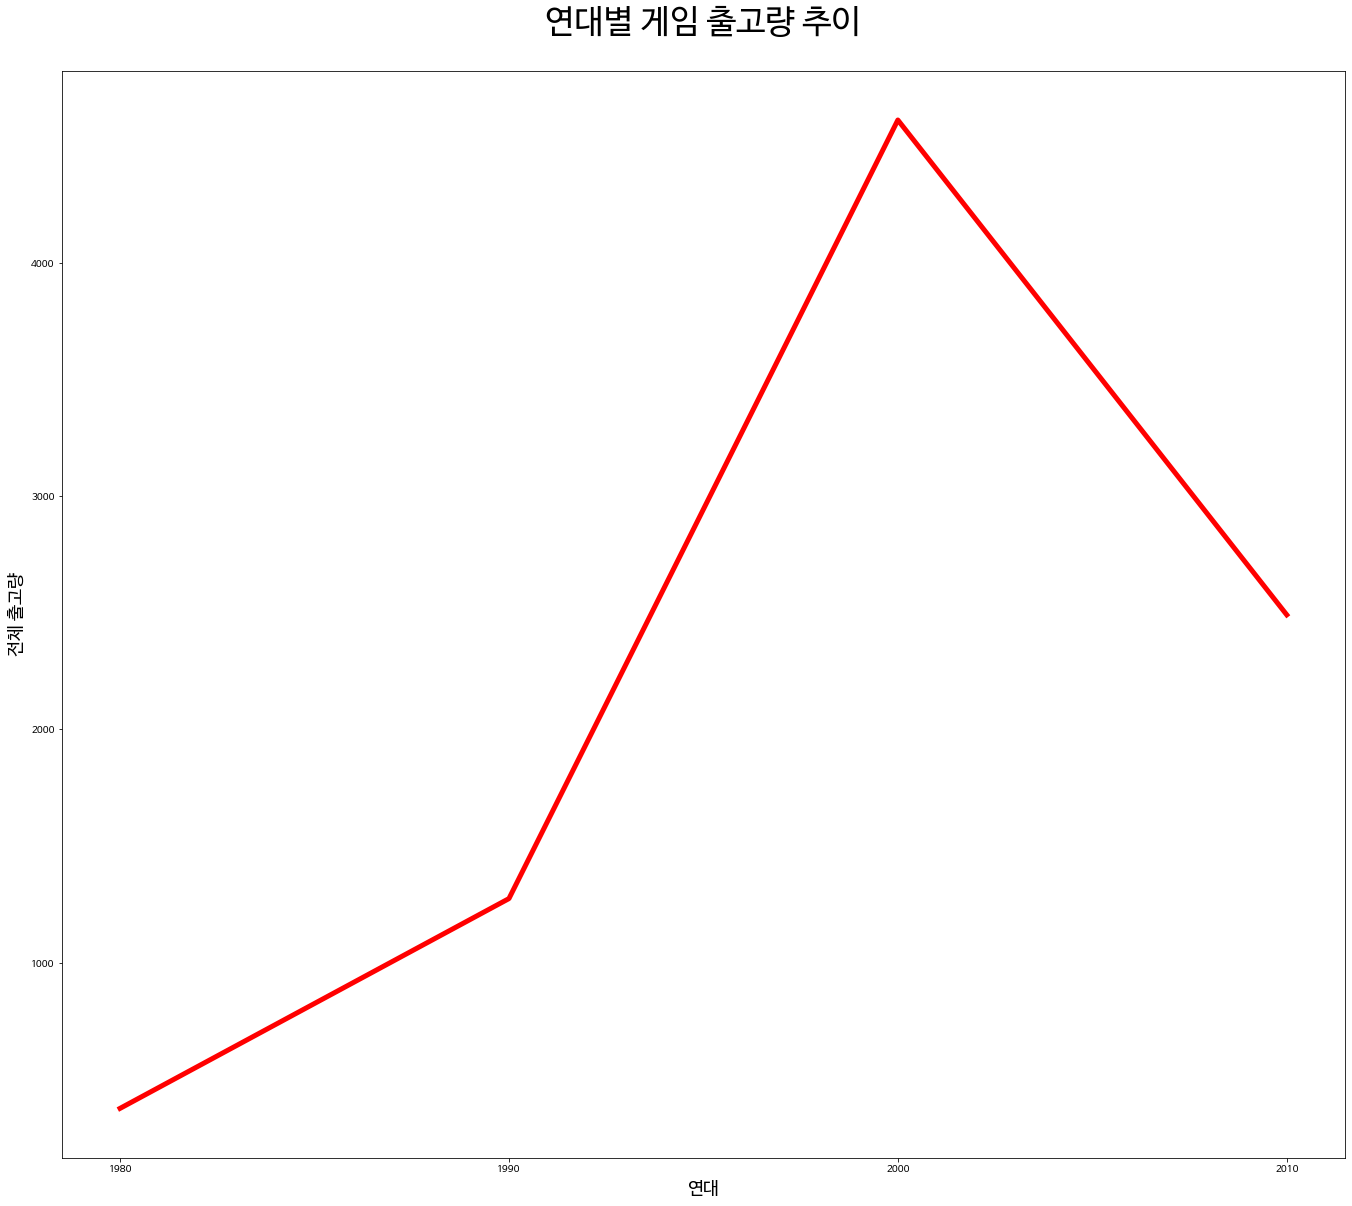

In [17]:
dfYrBin = df.groupby(by=['Year_Group']).Total_Sales.sum().reset_index()
dfYrBin['changeRatio'] = dfYrBin.Total_Sales.pct_change()        
display(dfYrBin)
plt.figure(figsize=(23, 20))
plt.title("연대별 게임 출고량 추이", fontsize=33, loc='center', y=1.03)
plt.xlabel('연대', fontsize=18)
plt.ylabel('전체 출고량', fontsize=18)
sns.lineplot(data=dfYrBin, x='Year_Group', y='Total_Sales', color='r', linewidth = 5);

#### 연도별 콘솔 종류별 추이

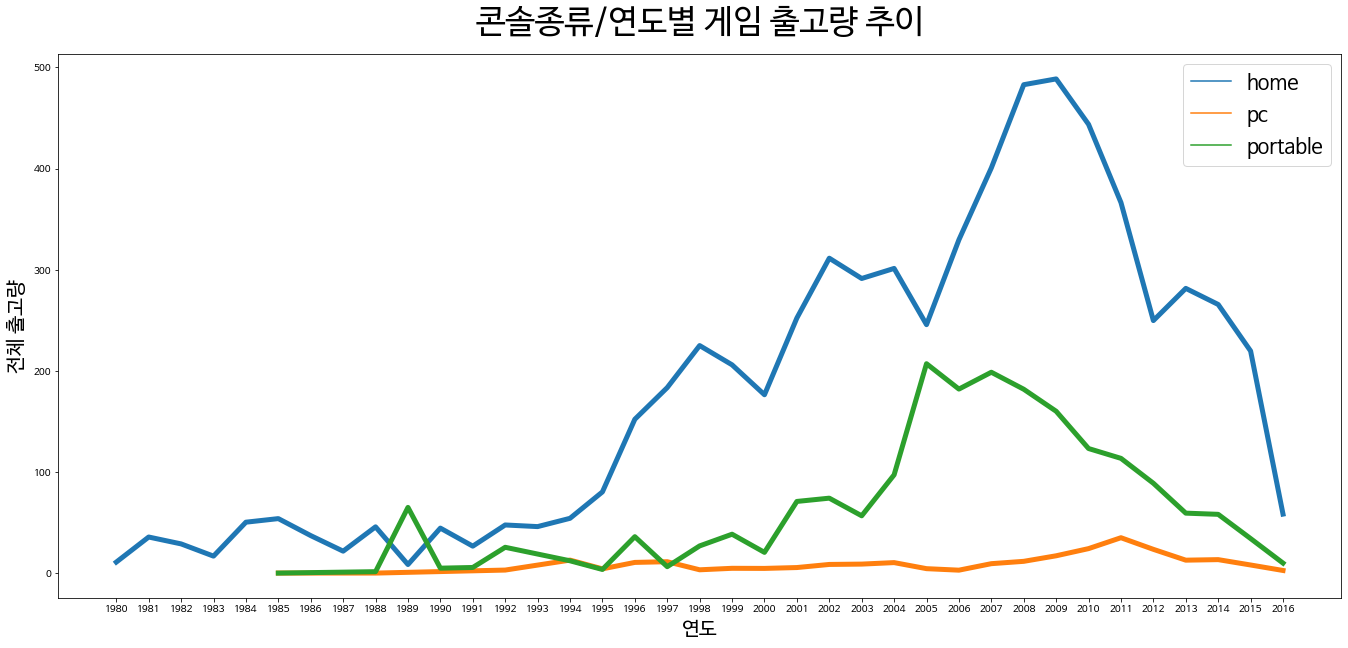

In [18]:
dfYrCnsl = df.groupby(by=['Year','Console']).agg({'Total_Sales':'sum'}).reset_index().sort_values(by=['Console', 'Year'])

plt.figure(figsize=(23, 10))
plt.title("콘솔종류/연도별 게임 출고량 추이", fontsize=33, loc='center', y=1.03)
plt.xlabel('연도', fontsize=20)
plt.ylabel('전체 출고량', fontsize=20)
sns.lineplot(data=dfYrCnsl, x='Year', y='Total_Sales', hue='Console', linewidth = 5).legend(fontsize=20);

#### 최근 3년 기준 Top3 플랫폼/연도별 추이

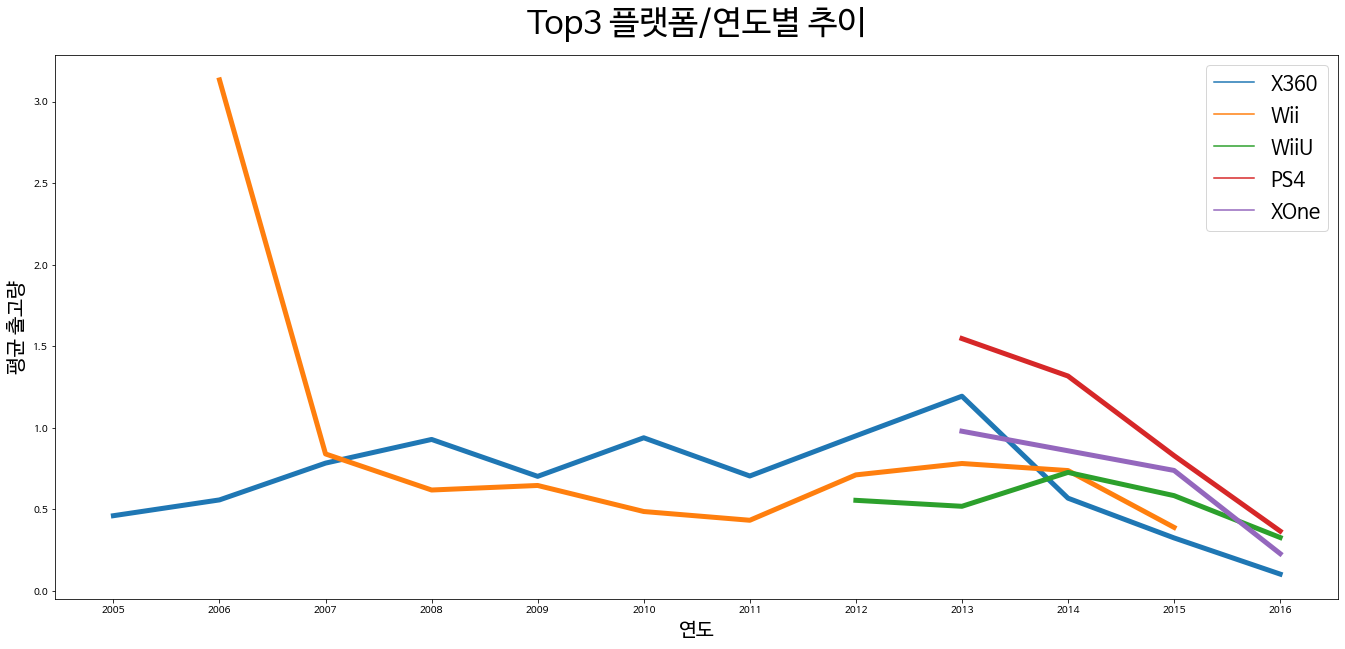

In [19]:
dfPltf3y = df[df['Year'] >= "2014"].groupby(by=['Platform']).agg({'Total_Sales':'mean'}).reset_index().sort_values(by=['Platform'])
q50_cut = dfPltf3y.sort_values(by='Total_Sales', ascending=False).Total_Sales.quantile(q=0.5, interpolation='nearest')
top_platforms = list(dfPltf3y[dfPltf3y['Total_Sales'] > q50_cut].sort_values(by='Total_Sales', ascending=False).Platform.unique()) # 백분위 50 이상 상위 판매량 플랫폼

dfTopPltYr = df[df['Platform'].isin(top_platforms)].groupby(by=['Platform', 'Year']).agg({'Total_Sales':'mean'}).reset_index().sort_values(by=['Year'])

plt.figure(figsize=(23, 10))
plt.title("Top3 플랫폼/연도별 추이", fontsize=33, loc='center', y=1.03)
plt.xlabel('연도', fontsize=20)
plt.ylabel('평균 출고량', fontsize=20)
sns.lineplot(data=dfTopPltYr, x='Year', y='Total_Sales', hue='Platform', linewidth = 5).legend(fontsize=20);

#### 최근 3년 기준 Top3 장르/연도별 추이

##### 연도별 분류

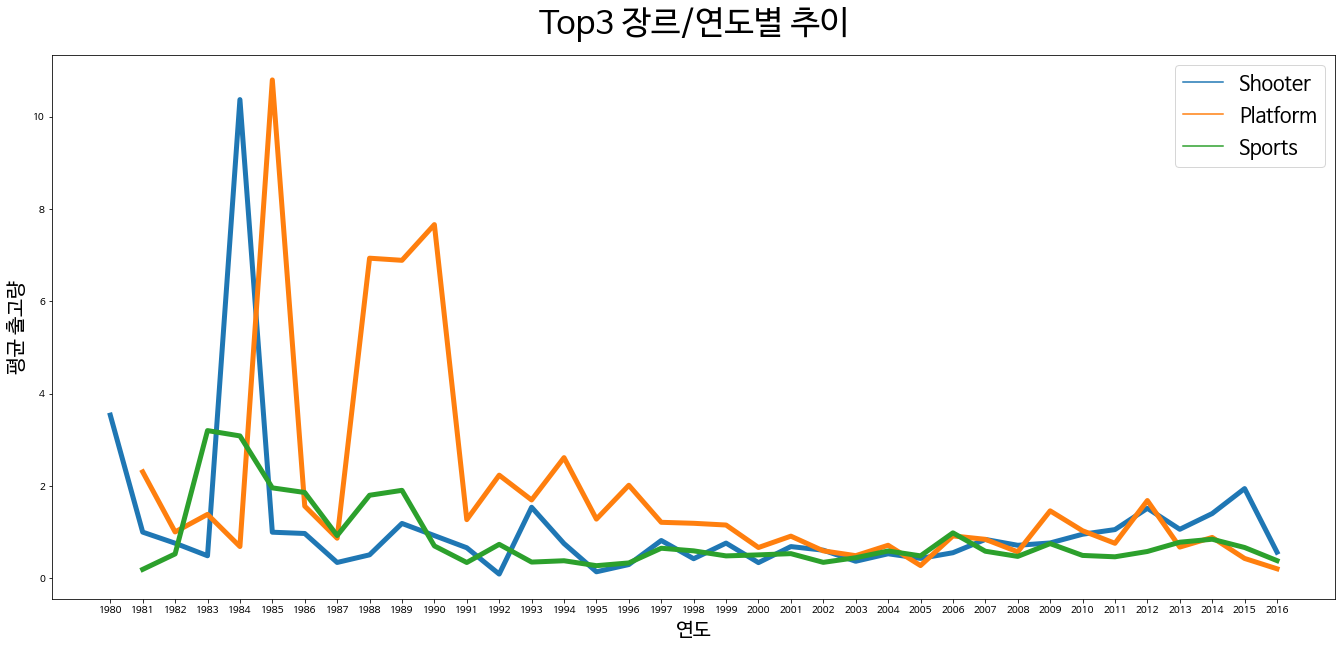

In [20]:
dfGnre3yr = df[df['Year'] >= "2014"].groupby(by=['Genre']).agg({'Total_Sales':'mean'}).reset_index().sort_values(by=['Genre'])
q75_cut = dfGnre3yr.sort_values(by='Total_Sales', ascending=False).Total_Sales.quantile(q=0.75, interpolation='nearest')
top_genres = list(dfGnre3yr[dfGnre3yr['Total_Sales'] > q75_cut].sort_values(by='Total_Sales', ascending=False).Genre.unique()) # 백분위 75 이상 상위 판매량 플랫폼
dfTopGnreYr = df[df['Genre'].isin(top_genres)].groupby(by=['Genre', 'Year']).agg({'Total_Sales':'mean'}).reset_index().sort_values(by=['Year']).reset_index()
plt.figure(figsize=(23, 10))
plt.title("Top3 장르/연도별 추이", fontsize=33, loc='center', y=1.03)
plt.xlabel('연도', fontsize=20)
plt.ylabel('평균 출고량', fontsize=20)
sns.lineplot(data=dfTopGnreYr, x='Year', y='Total_Sales', hue='Genre', linewidth = 5).legend(fontsize=20);

##### 연대별 분류

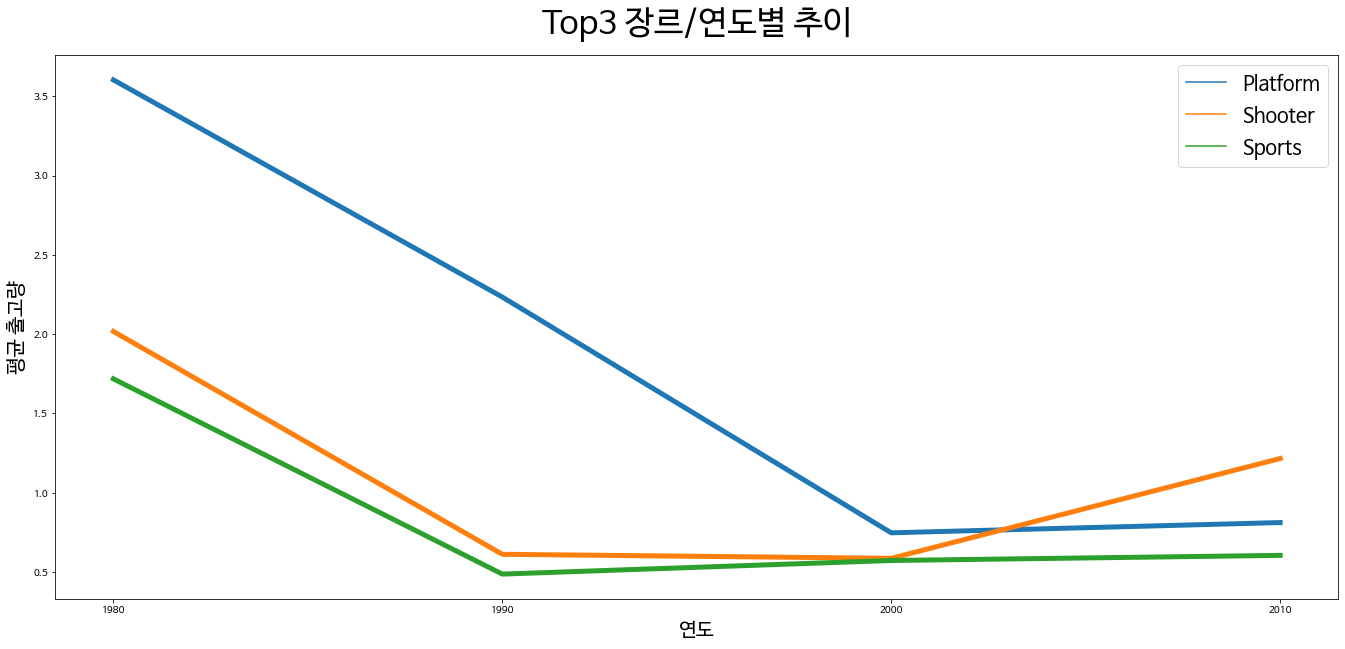

In [21]:
dfTopGnreYr['Year_Group'] = pd.cut(dfTopGnreYr['Year'], bins, labels=groups)
dfTopGnreYrBin = dfTopGnreYr.groupby(by=['Year_Group', 'Genre']).Total_Sales.mean().reset_index()
plt.figure(figsize=(23, 10))
plt.title("Top3 장르/연도별 추이", fontsize=33, loc='center', y=1.03)
plt.xlabel('연도', fontsize=20)
plt.ylabel('평균 출고량', fontsize=20)
sns.lineplot(data=dfTopGnreYrBin, x='Year_Group', y='Total_Sales', hue='Genre', linewidth = 5).legend(fontsize=20);

### 비모수검정

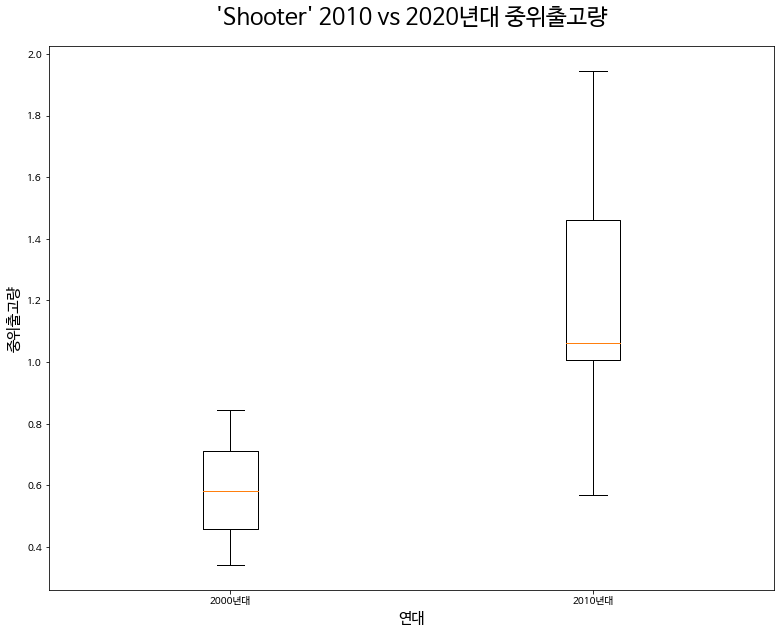

mean(Shooter=0.5862938530201933, Shooter=1.2157493644086503) 
 median(Shooter=0.583283166109253, Shooter=1.063220338983051) 
 ShapiroResult(statistic=0.5096548199653625, pvalue=2.4713584171379427e-17) 
 LeveneResult(statistic=3.195213520374607, pvalue=0.09407165210898326) 
 t-testResult(statistic=-4.101883539917036, p-value=0.0009426525933573611) 
 WelchResult(statistic=-4.101883539917036, p-value=0.0009426525933573611) 
 RanksumsResult(statistic=-2.9277002188455996, pvalue=0.0034147911781178164)


In [22]:
dfTopGnreYr['Year_Group'] = pd.cut(dfTopGnreYr['Year'], bins, labels=groups)

grpA = dfTopGnreYr.loc[(dfTopGnreYr['Genre'] == 'Shooter') & (dfTopGnreYr['Year_Group'] == '2000')]
grpB = dfTopGnreYr.loc[(dfTopGnreYr['Genre'] == 'Shooter') & (dfTopGnreYr['Year_Group'] == '2010')]

mean = "mean({}={}, {}={})".format('Shooter', np.mean(grpA.Total_Sales), 'Shooter', np.mean(grpB.Total_Sales))
median = "median({}={}, {}={})".format('Shooter', np.median(grpA.Total_Sales), 'Shooter', np.median(grpB.Total_Sales))
shapiroT = shapiro(dfTopGnreYr.Total_Sales) # 정규분포
leveneT = stats.levene(grpA.Total_Sales, grpB.Total_Sales, center='median') # 등분산성
t_stat, p_val = stats.ttest_ind(grpA.Total_Sales, grpB.Total_Sales, equal_var=True, alternative='two-sided')
studentT = "t-testResult(statistic={}, p-value={})".format(t_stat, p_val)
welchT = "WelchResult(statistic={}, p-value={})".format(t_stat, p_val)
ranksumsT = ranksums(grpA.Total_Sales, grpB.Total_Sales) # 비모수 검정    
plot_data = [grpA.Total_Sales, grpB.Total_Sales] 

plt.figure(figsize=(13, 10))

plt.title("'Shooter' 2010 vs 2020년대 중위출고량", fontsize=23, loc='center', y=1.03)
plt.xlabel('연대', fontsize=15)
plt.ylabel('중위출고량', fontsize=15)


plt.boxplot(plot_data)

plt.xticks([1, 2], ['2000년대', '2010년대'])
plt.show()

print(mean, "\n", median, "\n", shapiroT, "\n", leveneT, "\n", studentT, "\n", welchT, "\n", ranksumsT)